In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import os
print(tf.__version__)

2.4.1


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q':"title='Test.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Data.zip')

In [ ]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [ ]:
!unzip Data.zip

Archive:  Data.zip
replace Test/Mask/2070.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
base_dir = '/content'
os.listdir(base_dir)

['.config',
 'Mask3.jfif',
 'Mask2.jfif',
 'adc.json',
 'Train',
 'NoMask2.jpeg',
 'NoMask.jpeg',
 'Mask.jfif',
 'Data.zip',
 'Validation',
 'Test',
 'sample_data']

In [ ]:
train_dir = os.path.join(base_dir,
                         'Train')
test_dir = os.path.join(base_dir,
                        'Test')

In [ ]:
train_mask_dir = os.path.join(train_dir, 'Mask')
train_nomask_dir = os.path.join(train_dir, 'Non Mask')

In [ ]:
train_mask_names = os.listdir(train_mask_dir)
print(train_mask_names[:10])

train_nomask_names = os.listdir(train_nomask_dir)
print(train_nomask_names[:10])

['1323.jpg', '0018.jpg', '1173.jpg', '1635.jpg', '1487.jpg', '0128.png', '0770.jpg', '1554.jpg', '0719.jpg', '0731.jpg']
['100.jpg', '134.jpg', '177.jpg', '241.jpg', '248.jpg', '232.jpg', '301.jpg', '184.jpg', '187.jpg', '271.jpg']


In [ ]:
print("Total Training Images with masks: ", len(train_mask_names))
print("Total Training Images with no masks: ", len(train_nomask_names))

Total Training Images with masks:  300
Total Training Images with no masks:  300


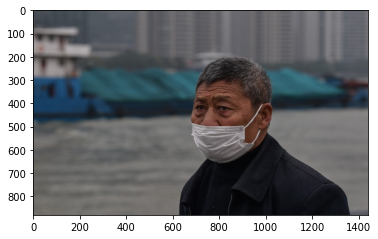

In [ ]:
from PIL import Image
img = Image.open(os.path.join(train_mask_dir, train_mask_names[0]))
plt.imshow(img)

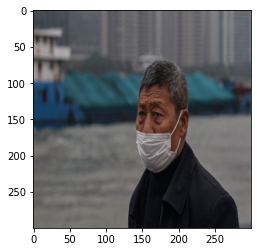

In [ ]:
import cv2 as cv
for i in train_mask_names:
  i = Image.open(os.path.join(train_mask_dir, i))
  i = i.resize((300, 300))
img = Image.open(os.path.join(train_mask_dir, train_mask_names[0])).resize((300,300))
plt.imshow(img)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model, layers

pre_trained_model = InceptionV3(input_shape = (300, 300, 3), 
                                include_top = False, 
                                weights = "imagenet")
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 17, 17, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                 
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x) 
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x) 

model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(rescale = 1/255)
train_generator = train_data.flow_from_directory(
    train_dir,
    target_size = (300, 300),
    batch_size = 64,
    class_mode = 'binary')

test_data = ImageDataGenerator(rescale = 1/255)
test_generator = test_data.flow_from_directory(
    test_dir,
    target_size = (300,300),
    batch_size = 32,
    class_mode = 'binary'
)

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,  
      epochs=5,
      verbose=1,
      validation_data = test_generator,
      validation_steps = 3
      )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
10/10 [==============================] - 148s 14s/step - loss: 1.7651 - accuracy: 0.6992 - val_loss: 0.0623 - val_accuracy: 0.9792
Epoch 2/5
10/10 [==============================] - 143s 14s/step - loss: 0.0468 - accuracy: 0.9881 - val_loss: 0.0142 - val_accuracy: 0.9896
Epoch 3/5
10/10 [==============================] - 140s 14s/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0248 - val_accuracy: 0.9792
Epoch 4/5
10/10 [==============================] - 154s 16s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9792
Epoch 5/5
10/10 [==============================] - 141s 14s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9792


ConvNet without using Transfer Learning. For a small dataset, it is very unstable as seen below

In [ ]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
 # tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
 # tf.keras.layers.MaxPooling2D(2, 2),
 # tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
 # tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [ ]:
model2.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

print(model2.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_113 (Conv2D)          (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 78400)            

In [ ]:
history2 = model2.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=10,
      verbose=1,
      validation_data = test_generator,
      validation_steps = 3
      )

Epoch 1/10
10/10 [==============================] - 67s 6s/step - loss: 6.3727 - accuracy: 0.4966 - val_loss: 0.8238 - val_accuracy: 0.5104
Epoch 2/10
10/10 [==============================] - 63s 6s/step - loss: 0.8013 - accuracy: 0.6587 - val_loss: 0.6472 - val_accuracy: 0.5833
Epoch 3/10
10/10 [==============================] - 65s 6s/step - loss: 0.5525 - accuracy: 0.7904 - val_loss: 0.5467 - val_accuracy: 0.7396
Epoch 4/10
10/10 [==============================] - 64s 6s/step - loss: 0.5388 - accuracy: 0.7879 - val_loss: 0.3746 - val_accuracy: 0.8750
Epoch 5/10
10/10 [==============================] - 64s 6s/step - loss: 0.3474 - accuracy: 0.8628 - val_loss: 0.2834 - val_accuracy: 0.8646
Epoch 6/10
10/10 [==============================] - 63s 6s/step - loss: 0.2004 - accuracy: 0.9250 - val_loss: 0.2744 - val_accuracy: 0.8958
Epoch 7/10
10/10 [==============================] - 66s 7s/step - loss: 0.2981 - accuracy: 0.8858 - val_loss: 0.3427 - val_accuracy: 0.8333
Epoch 8/10
10/10 [==

(1, 300, 300, 3)
[[0.8886702]]
[[0.97538733]]


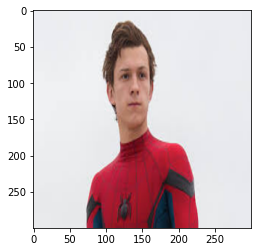

In [ ]:

from keras.preprocessing import image
from google.colab import files
import numpy as np
uploaded = files.upload()

'''for keys in uploaded.keys():
  path = '/content/'+keys
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  print(images[0].shape)
  classes = model.predict('/content/Mask.jfif', batch_size=10)
  print(classes)
  plt.imshow(images[0])
  '''

#classes = model.predict('/content/Mask.jfif', batch_size=10)
img = Image.open('/content/NoMask2.jpeg').resize((300,300))
im = np.array(img)
im = np.expand_dims(im, axis = 0).astype('float32')/255
print(im.shape)
plt.imshow(im[0])
classes = model.predict(im, batch_size = 1)
classes2 = model2.predict(im, batch_size = 1)
print(classes)
print(classes2)